# Transformer implementation

In [1]:
import math
import torch
from torch import nn

device = torch.device("cuda")

max_seq_len, embedding_size, head_count, layer_count, batch_size, epoch_count = 128, 256, 8, 8, 256, 100


The class `Embeddings` is designed to perform embedding of input indices into continuous vector representations. 

`self.embed` is a network layer responsible for mapping discrete indices to vector representations. 

The `forward` method defines the forward pass of the neural network. The forward pass is the process of taking the input, passing it through networks layers and then getting the final output. 

In [2]:
class Embedding(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    def forward(self, x):
        out = self.embed(x)
        return out

In [3]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, embed_dim, max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.embed_dim = embed_dim
        pe = torch.zeros(max_seq_len, self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0, self.embed_dim, 2):
                pe[pos, i] = math.sin(pos / (10000 ** (2 * i / self.embed_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** (2 * (i + 1) / self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)       # pre-calculate and freeze

    def forward(self, x):
        seq_len = x.size(1)
        return x * math.sqrt(self.embed_dim) + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)
        # return x + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)

Multihead attention can be thought of as a bunch of stacked attention primitives. 

In the attention, we have several channels. We split the channels into attention heads. Then we apply the attention mechanism to the heads and, finnalt, gather the results into one representation. 

In [4]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.single_head_dim = self.embed_dim // self.num_heads   # 512 / 8 = 64, every head takes its part of the input
        self.query_matrix = torch.nn.Linear(self.embed_dim, self.embed_dim, bias=False)  # a big matrix for the whole input
        self.key_matrix = torch.nn.Linear(self.embed_dim, self.embed_dim, bias=False)    # we will split the heads later on
        self.value_matrix = torch.nn.Linear(self.embed_dim, self.embed_dim, bias=False)
        self.mixer = torch.nn.Linear(self.embed_dim, self.embed_dim)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Q, K, V shapes are (batch x length x single_head_dim) == (32 x 10 x 64)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.single_head_dim)
        # scores shape is (batch x length x length) == (32 x 10 x 10)
        if mask is not None:
            scores = scores.masked_fill(mask == False, -1e9)    # put large negative numbers to positions where mask == False
        probs = torch.softmax(scores, dim=-1)                   # transform scores to probabilities (B x L x L)
                                                                # for each sample in the batch tell how ith token is important to jth token
        return torch.matmul(probs, V)                           # re-weigh values according to the probabilities

    def split_heads(self, x):
        batch_size, seq_length, embed_dim = x.size()            # B x L x D
        assert self.embed_dim == embed_dim
        return x.view(                                          # B x L x H x d
            batch_size,
            seq_length,
            self.num_heads,
            self.single_head_dim,
        ).transpose(1, 2)                                       # B x H x L x d
        
    def combine_heads(self, x):
        batch_size, num_heads, seq_length, single_head_dim = x.size()
        assert self.num_heads == num_heads
        assert self.single_head_dim == single_head_dim
        # B x H x L x d   => 
        # B x L x H x d   =>
        # B x L x D
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.embed_dim)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.query_matrix(Q))
        K = self.split_heads(self.key_matrix(K))
        V = self.split_heads(self.value_matrix(V))        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        return self.mixer(self.combine_heads(attn_output))

In [5]:
class FeedForward(torch.nn.Module):
    def __init__(self, embed_dim, expansion):
        super(FeedForward, self).__init__()
        self.fc1 = torch.nn.Linear(embed_dim, embed_dim * expansion)
        self.fc2 = torch.nn.Linear(embed_dim * expansion, embed_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # expand => non-linearity => shrink
        return self.fc2(self.relu(self.fc1(x)))

In [6]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, expansion, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads)
        self.feed_forward = FeedForward(embed_dim, expansion)
        self.norm1 = torch.nn.LayerNorm(embed_dim)
        self.norm2 = torch.nn.LayerNorm(embed_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, mask):
        # (attention => droupout) + residual => norm
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, mask)))
        # (MLP => dropout) + residual => norm
        return self.norm2(x + self.dropout(self.feed_forward(x)))

In [7]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, expansion, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads)
        self.cross_attn = MultiHeadAttention(embed_dim, num_heads)
        self.feed_forward = FeedForward(embed_dim, expansion)
        self.norm1 = torch.nn.LayerNorm(embed_dim)
        self.norm2 = torch.nn.LayerNorm(embed_dim)
        self.norm3 = torch.nn.LayerNorm(embed_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        # self attention (decoder x decoder)
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, tgt_mask)))
        # cross attention (decoder x encoder), note that queries are from decoder, keys and values - from encoder
        x = self.norm2(x + self.dropout(self.cross_attn(x, encoder_output, encoder_output, src_mask)))
        # MLP + dropout + residual + norm
        return self.norm3(x + self.dropout(self.feed_forward(x)))

In [8]:
class EncoderDecoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, expansion, max_seq_length, dropout):
        super(EncoderDecoder, self).__init__()
        # we could split encoder and decoder embeddings
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_seq_length)
        self.encoder_layers = torch.nn.ModuleList([EncoderLayer(embed_dim, num_heads, expansion, dropout) for _ in range(num_layers)])
        self.decoder_layers = torch.nn.ModuleList([DecoderLayer(embed_dim, num_heads, expansion, dropout) for _ in range(num_layers)])
        self.fc = torch.nn.Linear(embed_dim, vocab_size)
        self.dropout = torch.nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.embedding(tgt)))
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
        output = self.fc(dec_output)
        return output

In [9]:
class Encoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, expansion, max_seq_length, dropout):
        super(Encoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_seq_length)
        self.layers = torch.nn.ModuleList([EncoderLayer(embed_dim, num_heads, expansion, dropout) for _ in range(num_layers)])
        self.fc = torch.nn.Linear(embed_dim, vocab_size)
        self.dropout = torch.nn.Dropout(dropout)

    def generate_mask(self, src):
        mask = (src != 0).unsqueeze(1).unsqueeze(3)
        seq_length = src.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(src.device)
        mask = mask & nopeak_mask
        return mask

    def forward(self, src):
        mask = self.generate_mask(src)
        embedded = self.dropout(self.positional_encoding(self.embedding(src)))
        for layer in self.layers:
            embedded = layer(embedded, mask)
        return self.fc(embedded)

In [10]:
import requests

all_shakespeare = requests.get("https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt").content.decode()
print(len(all_shakespeare))

5458199


In [11]:
dictionary = ["<empty>", "<start>", "<end>"] + list(set(all_shakespeare))
print(dictionary)
print(len(dictionary))

sym2idx = {s: i for i, s in enumerate(dictionary)}
print(sym2idx)

['<empty>', '<start>', '<end>', '&', 'e', 'x', '%', "'", 'l', '-', 'r', ')', 'Y', '`', '.', 'i', 'W', 'o', '|', '[', 'X', 'j', '"', 'H', 's', 'J', 'a', 'A', '!', 'y', ';', 'N', '0', 'f', 'u', 'Q', '>', 'L', '9', 'G', 'w', 'T', 'p', '<', 'M', 'b', 'k', '_', '4', 'K', ']', 'm', '?', '}', 'I', 'V', '2', 'U', 'd', 'O', '~', '=', '#', '*', 'v', '3', 'z', '@', 'C', 'S', '1', 'c', 'Z', ',', 'D', 'P', '7', 'F', '5', 'R', 't', 'E', '8', 'n', 'B', 'g', ':', '/', '\n', '(', 'h', '6', ' ', 'q']
94
{'<empty>': 0, '<start>': 1, '<end>': 2, '&': 3, 'e': 4, 'x': 5, '%': 6, "'": 7, 'l': 8, '-': 9, 'r': 10, ')': 11, 'Y': 12, '`': 13, '.': 14, 'i': 15, 'W': 16, 'o': 17, '|': 18, '[': 19, 'X': 20, 'j': 21, '"': 22, 'H': 23, 's': 24, 'J': 25, 'a': 26, 'A': 27, '!': 28, 'y': 29, ';': 30, 'N': 31, '0': 32, 'f': 33, 'u': 34, 'Q': 35, '>': 36, 'L': 37, '9': 38, 'G': 39, 'w': 40, 'T': 41, 'p': 42, '<': 43, 'M': 44, 'b': 45, 'k': 46, '_': 47, '4': 48, 'K': 49, ']': 50, 'm': 51, '?': 52, '}': 53, 'I': 54, 'V': 55

In [12]:
import random

random.seed(42)

#data = all_shakespeare.split("\n\n")
#data = list(filter(lambda x: x and len(x) < max_seq_len, data))
data = [all_shakespeare[i:i+max_seq_len-1] for i in range(0, len(all_shakespeare), max_seq_len)]
random.shuffle(data)

print(len(data))
print(data[77])
print(len(data[77]))

42643
If the tagrag people did not clap him and hiss him
    according as he pleased and displeased them, as they use to do
    the p
127


In [13]:
train = [data[i] for i in range(len(data)) if i % 10 != 0]
test = [data[i] for i in range(len(data)) if i % 10 == 0]

print(train[-5])
print("")
print(test[-5])

 both together heav'd it up,
    We'll both together lift our heads to heaven,
    And never more abase our sight so low
    As

thee.
  PRINCESS OF FRANCE. Honey, and milk, and sugar; there is three.
  BEROWNE. Nay, then, two treys, an if you grow so nice


In [14]:
src = torch.tensor([[1, 2, 3, 0]]).to(device)
model = Encoder(len(dictionary), embedding_size, head_count, layer_count, 4, max_seq_len, 0.1).to(device)
mask = model.generate_mask(src)
print(mask)
print(sum(p.numel() for p in model.parameters()))

tensor([[[[ True, False, False, False],
          [ True,  True, False, False],
          [ True,  True,  True, False],
          [False, False, False, False]]]], device='cuda:0')
6360158


In [15]:
import numpy as np

def generate(model, len_limit):
    model.eval()
    with torch.no_grad():
        result = ["<start>"] + list("CAESAR.")
        while len(result) < len_limit:
            x = torch.tensor([[sym2idx[x] for x in result]]).to(device)
            y = model(x)
            y = y[0][-1].cpu().numpy()
            y = np.exp(y)
            y /= np.sum(y)
            #print(" ".join(map(lambda t: "{:.4f}".format(t), y)) + "\n")
            x = dictionary[np.random.choice(y.shape[0], p = y)]
            if x in ["<start>", "<end>", "<empty>"]:
                break
            result.append(x)
        return ''.join(result[1:])

print(generate(model, max_seq_len))

CAESAR.of-Ez


100%|██████████| 4265/4265 [00:02<00:00, 1551.36it/s]


Epoch 0 loss: 3.24760 3.21206
CAESAR.ieat b
  eDt  ibsra swhdBep ou S a'ee loendiL wtuFLr Xty 


100%|██████████| 4265/4265 [00:02<00:00, 1551.67it/s]


Epoch 1 loss: 2.50873 2.19613
CAESAR. I And llow atcin mand; and nve win knowesw totis your he,ee ey a t forat ou.
   Lt Ther; nomi


100%|██████████| 4265/4265 [00:02<00:00, 1551.49it/s]


Epoch 2 loss: 2.13216 1.86206
CAESAR. Say, you my blike ear
     Oul, he wrie comize a be and the Patifura,
    For is liv ougleng evirt.
                   


100%|██████████| 4265/4265 [00:02<00:00, 1550.98it/s]


Epoch 3 loss: 1.98540 1.72500
CAESAR. As be don! ath bastt mones her heads her lighte suroucts
     But not that froy my bas of my self.
   Appeasencer Eng t


100%|██████████| 4265/4265 [00:02<00:00, 1552.05it/s]


Epoch 4 loss: 1.86172 1.65766
CAESAR. Do how ton.
  BETROMICT GUENTUES and ANE his pround
 FIRTH FRAMON. How; I wreany let of ans him
    Binde-giOTELLON.  G


100%|██████████| 4265/4265 [00:02<00:00, 1551.95it/s]


Epoch 5 loss: 1.71199 1.56668
CAESAR. You sincks.
  KING HENRY. This hath'now
  MECBETH PANTINUS and CLOWNGATINA, hold free peittorice abGuestes
   Fairs in 


100%|██████████| 4265/4265 [00:02<00:00, 1551.00it/s]


Epoch 6 loss: 1.71849 1.49604
CAESAR. And yet forliends and mann- that 'twen thy bots, which countent turn of the for
    this Come, Sir Johner. Good Lordon,


100%|██████████| 4265/4265 [00:02<00:00, 1551.64it/s]


Epoch 7 loss: 1.63625 1.46841
CAESAR. What I say, bark, shall I do who to
    man all limp as here soul every man of death;
    The was handst reme


100%|██████████| 4265/4265 [00:02<00:00, 1552.02it/s]


Epoch 8 loss: 1.55089 1.42579
CAESAR. Sir, I would thou braught, sweet might,
   Even the DUKE OF COUNTES

  CLOWN. Lo'


100%|██████████| 4265/4265 [00:02<00:00, 1551.64it/s]


Epoch 9 loss: 1.53541 1.40836
CAESAR. For sweets take all the ride, for that worms a should call'ry;
    The trainor and heart be expect?
    Now with in hea


100%|██████████| 4265/4265 [00:02<00:00, 1552.49it/s]


Epoch 10 loss: 1.52040 1.39380
CAESAR. ACHILLOPITES and SYRACUSE OF FRANCE, 'tis nation word.'
  Cal. I this it be mid;
    In thou cold rod! I make a tongue 


100%|██████████| 4265/4265 [00:02<00:00, 1551.73it/s]


Epoch 11 loss: 1.55135 1.36630
CAESAR. What shall remediates, it that; whose pail,
    And the bellock


100%|██████████| 4265/4265 [00:02<00:00, 1551.35it/s]


Epoch 12 loss: 1.45035 1.35796
CAESAR. A tick
     And with his night, uncleanful cause attendedy.  
  MESSENGER. As words this the same, that's tell my nusti


100%|██████████| 4265/4265 [00:02<00:00, 1552.15it/s]


Epoch 13 loss: 1.43136 1.34846
CAESAR. That I do not ignorant with your want what is beast; -
    Alacks thou great without patient,
    My peace good and fri


100%|██████████| 4265/4265 [00:02<00:00, 1551.94it/s]


Epoch 14 loss: 1.40751 1.33233
CAESAR. A beloved with him; and she is love twice in his excuse,
    Which, all till delight unwh


100%|██████████| 4265/4265 [00:02<00:00, 1551.86it/s]


Epoch 15 loss: 1.39170 1.33621
CAESAR. O, woman, faith, for how you with here a shortify- of a vinite
    world, there is thenas arms.  
  GRUMIO. Now, draw m


100%|██████████| 4265/4265 [00:02<00:00, 1551.63it/s]


Epoch 16 loss: 1.37368 1.31703
CAESAR. Will you be, Edward!
    The murning is goat to a chase.
    Now pettition, batter, but, which is i


100%|██████████| 4265/4265 [00:02<00:00, 1552.64it/s]


Epoch 17 loss: 1.35944 1.30926
CAESAR. is like a little of Harry.
DROMIO OF EPHESUS. Indeed, desire your kingsman.
LUCIANA. Let us.
ANTelus 


100%|██████████| 4265/4265 [00:02<00:00, 1551.65it/s]


Epoch 18 loss: 1.34014 1.30321
CAESAR. Queen of Claudio Cressid, the compossible  
    Having troilus unto the that till I noble-
  CAPTAIN. Until this side o


100%|██████████| 4265/4265 [00:02<00:00, 1551.92it/s]


Epoch 19 loss: 1.31722 1.30324
CAESAR. Come kits in this ground-
  SHYLOCK. Unless his master, Master Timon's lordship; for this
    clocks, I am this supplih


100%|██████████| 4265/4265 [00:02<00:00, 1552.43it/s]


Epoch 20 loss: 1.30886 1.27877
CAESAR. How now, noble and my lord?
    This is nothing with my honour to me a fear of shall,
    By look himlife. What ask of 


100%|██████████| 4265/4265 [00:02<00:00, 1552.12it/s]


Epoch 21 loss: 1.29019 1.28258
CAESAR. It was gone and other fear; but alas, tell me they two
      prologues, wherein he are a bottle evil.
  SIR TOBY. That 


100%|██████████| 4265/4265 [00:02<00:00, 1552.14it/s]


Epoch 22 loss: 1.29883 1.27933
CAESAR. Nay, sweet noble here, good before our noble name
    Have weep fortune's repear'd so of tender.
  BANQUO. We then is g


100%|██████████| 4265/4265 [00:02<00:00, 1551.06it/s]


Epoch 23 loss: 1.28147 1.25921
CAESAR. [Aside] For thy letters be off.
    Get women. Stay but upon our offices. Heaven the motion;
    your pittiful thieves 


100%|██████████| 4265/4265 [00:02<00:00, 1552.37it/s]


Epoch 24 loss: 1.27085 1.26441
CAESAR. You are thrust, my sweet bodies, for well! You
    seem I will live I hold from hell; that better was him other
    Tha


100%|██████████| 4265/4265 [00:02<00:00, 1551.40it/s]


Epoch 25 loss: 1.26116 1.25451
CAESAR. Mich tell the venturous smile, conceaming; say then
    Have I to our countain them and a dukilly with cried.  
  PROSP


100%|██████████| 4265/4265 [00:02<00:00, 1551.54it/s]


Epoch 26 loss: 1.25262 1.25156
CAESAR. But how now has the princely in my men!
    By the hid not yet too hell destrain for this blood,
    So Lucilius pleas'


100%|██████████| 4265/4265 [00:02<00:00, 1552.19it/s]


Epoch 27 loss: 1.24431 1.25059
CAESAR. Sirrah-horroud est much these was substice  
    the rich nothing of opposite,  
    Your shorts are searched.
    We s


100%|██████████| 4265/4265 [00:02<00:00, 1551.63it/s]


Epoch 28 loss: 1.23950 1.24001
CAESAR. And with thee, I'll ried to you.
  TITUS. To savage, saint so Payacus! Wilt thou see thou toll'st?
  ARVANTS. Confesser


100%|██████████| 4265/4265 [00:02<00:00, 1551.54it/s]


Epoch 29 loss: 1.23547 1.24464
CAESAR. Sir Hastings.
  HERMIONE.  [Aside]  His hath no doubtful French father!
     De importunation, for a pallel assur'd as 


100%|██████████| 4265/4265 [00:02<00:00, 1551.45it/s]


Epoch 30 loss: 1.24555 1.24377
CAESAR. Come, good madam;  
    The news?
  THERSITES.  [Aside]  Whom shall I not think their headh of all crown.
     Some on 


100%|██████████| 4265/4265 [00:02<00:00, 1548.54it/s]


Epoch 31 loss: 1.22906 1.24973
CAESAR. Why down that's my brass.
  DUCHESS. Now she there curses; nothing, sir; there's a humble will design.
    And makes so


100%|██████████| 4265/4265 [00:02<00:00, 1547.80it/s]


Epoch 32 loss: 1.22434 1.23530
CAESAR. Give me my love are my light and prophecy,
    To speak him. She that thou follow the high spirits,
    Death dry me on


100%|██████████| 4265/4265 [00:02<00:00, 1548.41it/s]


Epoch 33 loss: 1.21127 1.23249
CAESAR. I'll fight her but
    He slew the gods stone: for every misfer his base,
    And all the Greece is beholding dignity
 


100%|██████████| 4265/4265 [00:02<00:00, 1548.59it/s]


Epoch 34 loss: 1.20460 1.23824
CAESAR. But you both resolved my hearts!

                              Enter three-

  TOUCHSTONE. Soft!
  TITUS. Greates Sign


100%|██████████| 4265/4265 [00:02<00:00, 1548.23it/s]


Epoch 35 loss: 1.20601 1.22771
CAESAR. Ay, believe anything long shall sung
    mine. She sats down, he is an edified for his book
    man.
  BIONDELLO.      


100%|██████████| 4265/4265 [00:02<00:00, 1548.24it/s]


Epoch 36 loss: 1.19935 1.22034
CAESAR. Not I.
  CLEOPATRA.  He were true, alas, why post the hour of Hector.
  CLEOPATRA. Say you down,
    If I, we'll as a v


100%|██████████| 4265/4265 [00:02<00:00, 1552.56it/s]


Epoch 37 loss: 1.19511 1.22931
CAESAR. Farewell, vouch gross-prosumed show me?
  DUKE. [He tell him he still down his grossly to be commonwealth.
  OLIVER. I'


100%|██████████| 4265/4265 [00:02<00:00, 1551.26it/s]


Epoch 38 loss: 1.19449 1.21761
CAESAR. Apale children brings, too much are at
    rheum from her father's time, too blush, in looks no only stone,
    for the


100%|██████████| 4265/4265 [00:02<00:00, 1551.64it/s]


Epoch 39 loss: 1.19448 1.20410
CAESAR. And that will nothing build to distribute sun;
    For O that foreveroous Diomed,
    And be speril'd.  
  SECOND SENAT


100%|██████████| 4265/4265 [00:02<00:00, 1551.84it/s]


Epoch 40 loss: 1.18717 1.21445
CAESAR. And! what royal space of continuine big-
    Even too high that no both high for innocent purpose
    His good return s


100%|██████████| 4265/4265 [00:02<00:00, 1552.29it/s]


Epoch 41 loss: 1.18587 1.19768
CAESAR. I'll see the Prink, and shall be already that the same this world
    policy to strong.
ANTIPHOLUS OF EPHESUS. Assistan


100%|██████████| 4265/4265 [00:02<00:00, 1551.90it/s]


Epoch 42 loss: 1.18164 1.21964
CAESAR. I am believe to th' finely that folly o'ertold.
  CLEOPATRA. O, they'll make again? You know at my achieve
    answer t


100%|██████████| 4265/4265 [00:02<00:00, 1552.68it/s]


Epoch 43 loss: 1.17918 1.20869
CAESAR. I am begs yours, and mude
    To see the end of your companion clesteress.
    If thou dost knock, I must be as it hope


100%|██████████| 4265/4265 [00:02<00:00, 1551.76it/s]


Epoch 44 loss: 1.17117 1.19913
CAESAR. By all his father's eyes; but we shall hear you come.
    for this thinis the news?
  SECOND MERCHANT. You die, cousin,


100%|██████████| 4265/4265 [00:02<00:00, 1552.16it/s]


Epoch 45 loss: 1.16937 1.21201
CAESAR. I believing to you, sir; my father lords; heavenly put on
    it, my father of my cheek will give up him not.
  IACHIMO


100%|██████████| 4265/4265 [00:02<00:00, 1552.53it/s]


Epoch 46 loss: 1.16877 1.21292
CAESAR. There's no longer word.
    Were you but where you hate me figure?
    He? Mince to repeat the line!                   


100%|██████████| 4265/4265 [00:02<00:00, 1551.83it/s]


Epoch 47 loss: 1.16699 1.19618
CAESAR. And so himself
    And clerk and many form; and, if you shut a gentlewoman name.
  PORTIA. Thou'ert carried to river wi


100%|██████████| 4265/4265 [00:02<00:00, 1551.71it/s]


Epoch 48 loss: 1.16130 1.22473
CAESAR. Loon, my lord,
    Hath want brings the wild with corees growing!
    O impression with lane child, and the menes,
    


100%|██████████| 4265/4265 [00:02<00:00, 1551.54it/s]


Epoch 49 loss: 1.16906 1.19427
CAESAR. You have had laugh'd to Friaridle, Grumio,
    And he thou takest heed on detracted doth right
    As once, could have 


100%|██████████| 4265/4265 [00:02<00:00, 1552.36it/s]


Epoch 50 loss: 1.15546 1.21480
CAESAR. Yet
     Doesdemona, their pleasants on their guards;
     Spirits and the master of thy knee, had no harm
     For any


100%|██████████| 4265/4265 [00:02<00:00, 1552.32it/s]


Epoch 51 loss: 1.15691 1.21107
CAESAR. O, that made you me!
  CASSIO. Of the world, sir; in continue I'll be not another son.
  IACHIMO. Nay.
  MASTER. Peace,


100%|██████████| 4265/4265 [00:02<00:00, 1550.01it/s]


Epoch 52 loss: 1.15336 1.20117
CAESAR. Dress me thy prison,
    So receive I learn:
    Go take heedful worthy to thy wisdom.
  PUCK. The gates here is slande


100%|██████████| 4265/4265 [00:02<00:00, 1550.62it/s]


Epoch 53 loss: 1.14807 1.20147
CAESAR. Sir John Stanley, my lord.
  ANTONY. What says there?
  SECOND CITIZEN. Your mind is one?
  CAESAR. What is honour woul


100%|██████████| 4265/4265 [00:02<00:00, 1551.76it/s]


Epoch 54 loss: 1.14460 1.21043
CAESAR. I find me, there doth she knee that I bring him me;
    it is dead aughter when am I, and say 't occasion between me.'


100%|██████████| 4265/4265 [00:02<00:00, 1551.29it/s]


Epoch 55 loss: 1.14791 1.18796
CAESAR. And why should I relent, what she is subject?
  AGUECHEEK. Ay, and one side?
  BELARIUS. Good pain and low, my lord.
  


100%|██████████| 4265/4265 [00:02<00:00, 1551.66it/s]


Epoch 56 loss: 1.14429 1.19569
CAESAR. The noble orch! Look of the gifts have by low pieceful
    mustarve fruit on whose necessity were at Shallow.  
  OCTAV


100%|██████████| 4265/4265 [00:02<00:00, 1551.23it/s]


Epoch 57 loss: 1.13855 1.19587
CAESAR. O, Leonato.
  PORTIA. Ladies to die with your ladyships!
  FALSTAFF. With all his places of company!
    By his fellows


100%|██████████| 4265/4265 [00:02<00:00, 1550.90it/s]


Epoch 58 loss: 1.13690 1.19527
CAESAR.  [Aside to CYMBELINE] Yes,
    As mask when I will, it will be the world
     Excellent fathers;
     Or else smell'd t


100%|██████████| 4265/4265 [00:02<00:00, 1552.12it/s]


Epoch 59 loss: 1.13675 1.19590
CAESAR. I must do fear you with your father
    And bid your love friends to your business in seeking on me.
  PAROLLES. All ri


100%|██████████| 4265/4265 [00:02<00:00, 1551.78it/s]


Epoch 60 loss: 1.13347 1.19961
CAESAR. Good King! what do you? What is he?
  ARVIRAGUS. Ay; I'll be sentinal.  
  HASTINGS. Ay, alas, this are talk'd of amine


100%|██████████| 4265/4265 [00:02<00:00, 1551.66it/s]


Epoch 61 loss: 1.13330 1.20959
CAESAR. This is shrine: 'I will to perfect it. It is true-
  PAULINA. You see me, you are weaker and not abled and not slept.
 


100%|██████████| 4265/4265 [00:02<00:00, 1551.91it/s]


Epoch 62 loss: 1.13524 1.20055
CAESAR. It was like a wanton leave her; an 'twould ignorance. Thou
    have made distrusted a few.
  ACHILLES. Though I have bl


100%|██████████| 4265/4265 [00:02<00:00, 1551.41it/s]


Epoch 63 loss: 1.13185 1.19991
CAESAR. Pray you break it, reconciles; I must you discipline.
    Thou saw'st no company, Cassio!
    Thy tendants that man sho


100%|██████████| 4265/4265 [00:02<00:00, 1551.69it/s]


Epoch 64 loss: 1.12828 1.18808
CAESAR. How does he heck? Owen these warbers hearts!
  CAESAR. The field of me-
  CORIOLANUS. I see them with them. To-morrow w


100%|██████████| 4265/4265 [00:02<00:00, 1552.28it/s]


Epoch 65 loss: 1.12729 1.20153
CAESAR. I am as pleas'd, let me before Master Slender's
    soul.
  SLENDER. If you be known that will be so, good night in the


100%|██████████| 4265/4265 [00:02<00:00, 1551.90it/s]


Epoch 66 loss: 1.12442 1.19551
CAESAR. You'll lengthen her win.
  ANTONY. She is nothing should think the town,
    That short and her malady tell; and-
    T


100%|██████████| 4265/4265 [00:02<00:00, 1552.02it/s]


Epoch 67 loss: 1.12328 1.19164
CAESAR. Where is he luck again?
  CALIBAN. Ay, but the state of mettle is more age.
    'Tis he in his eyes I sitting. I fear, 


100%|██████████| 4265/4265 [00:02<00:00, 1551.36it/s]


Epoch 68 loss: 1.12256 1.19310
CAESAR. Some sits call the King's. What, Friar [Laurence?]  What, does
    this people consul?
  CLOWN. What may you be work?
 


100%|██████████| 4265/4265 [00:02<00:00, 1551.66it/s]


Epoch 69 loss: 1.11758 1.18549
CAESAR. Is it now?
  JEWELLER. Not in our blood, a rebellion felt.
  TROILUS. Thou art wonderful sure Micians.
  NESTOR. Why, t


100%|██████████| 4265/4265 [00:02<00:00, 1551.80it/s]


Epoch 70 loss: 1.11817 1.19396
CAESAR. I will cut you under my Ross.
  ROSALINE. On me, I'll bear him shone to crist them again;
    But all about you are, I 


100%|██████████| 4265/4265 [00:02<00:00, 1552.13it/s]


Epoch 71 loss: 1.12142 1.17894
CAESAR. Within two peace.

                   Enter with VAUX

  DUKE. Here comes a free and mind.
  LUCIO. You, is she?  
  FI


100%|██████████| 4265/4265 [00:02<00:00, 1551.14it/s]


Epoch 72 loss: 1.11743 1.18949
CAESAR. I desire I do.
  ANTONIO. This is the poor stirrip; till age to fend,
    Go, prevail it too. This one standeth here
  


100%|██████████| 4265/4265 [00:02<00:00, 1551.17it/s]


Epoch 73 loss: 1.11302 1.19799
CAESAR. Ay, I care not, with the momenity!
  ALL. O, how exceeding were you a thousand dismiss
    To this very yea. Farewell, 


100%|██████████| 4265/4265 [00:02<00:00, 1551.75it/s]


Epoch 74 loss: 1.11128 1.21386
CAESAR. Then which Caesar do I run awhile.
  ANTONY. Mock myself is an other tomb;
    My phrase soul shall be gone unto a sigh


100%|██████████| 4265/4265 [00:02<00:00, 1551.88it/s]


Epoch 75 loss: 1.11513 1.18581
CAESAR. Why do you find our power?  
  CASSIO. She still, my lord, do you pish.
  BRUTUS. Nay, I'll none of her?
  CASSIUS. Do 


100%|██████████| 4265/4265 [00:02<00:00, 1551.98it/s]


Epoch 76 loss: 1.10979 1.19579
CAESAR. I would my brother here in Brutus and truly,
    Let Marcus give air hands deceive my sake.  
    My dearest are vile l


100%|██████████| 4265/4265 [00:02<00:00, 1551.37it/s]


Epoch 77 loss: 1.10660 1.20308
CAESAR. It is my cousin Belmont;
    I know him not what I have against your Grace,
    And then will not get us to this great 


100%|██████████| 4265/4265 [00:02<00:00, 1551.77it/s]


Epoch 78 loss: 1.10514 1.21585
CAESAR. That she is merciful.  
  OLIVIA. Caesar lovers Robert and Officer.
  SALERIO.                  Ay, and once more,
    


100%|██████████| 4265/4265 [00:02<00:00, 1552.34it/s]


Epoch 79 loss: 1.10746 1.18036
CAESAR. O, madam, I say! Take heed, day thou name; Sing.
    Your Highness is the King, England's crept!
  GLOUCESTER. You're b


100%|██████████| 4265/4265 [00:02<00:00, 1551.97it/s]


Epoch 80 loss: 1.10457 1.19432
CAESAR. Would your Grecian invited should go a fear
    Since you were cold?
  PEMBROKE. Not yours are twenty too, then, being 


100%|██████████| 4265/4265 [00:02<00:00, 1551.24it/s]


Epoch 81 loss: 1.10475 1.20081
CAESAR. And I proper did marriage to church
    in match, and anon the world awaked me.
    Ah, good my liege, my gracious lord


100%|██████████| 4265/4265 [00:02<00:00, 1551.28it/s]


Epoch 82 loss: 1.10135 1.20800
CAESAR. The maid at your consent discover; no other brains.
    If you could not be lame, sweet hands, which effects,
    Our p


100%|██████████| 4265/4265 [00:02<00:00, 1552.11it/s]


Epoch 83 loss: 1.10383 1.19593
CAESAR. Come, for you,
    It is our pains, comes here I send out;
    If thou art so far friends when you vary  
    Make your


100%|██████████| 4265/4265 [00:02<00:00, 1552.32it/s]


Epoch 84 loss: 1.10279 1.19473
CAESAR. Shall I lie for a word?
  QUEEN ELIZABETH. Not I, not all to be physic!
    Thanks, creep with thy beauty, bold with wo


100%|██████████| 4265/4265 [00:02<00:00, 1552.40it/s]


Epoch 85 loss: 1.09739 1.19410
CAESAR. Whither win, vain, are if they are but devis'd,
    I were not familiar by my counsel!
    Why dear Hector does go his 


100%|██████████| 4265/4265 [00:02<00:00, 1551.23it/s]


Epoch 86 loss: 1.09508 1.20332
CAESAR. Alas, I pray thee!
  ANNE. Alas, Caesar! take away her from Caesar,
    Take here one of York's mind of Brutus intendin


100%|██████████| 4265/4265 [00:02<00:00, 1552.94it/s]


Epoch 87 loss: 1.09510 1.19954
CAESAR. Were I may myself fills my son?
  LEPIDUS. Well, my lord.                                       Exit  
    [Lords, an


100%|██████████| 4265/4265 [00:02<00:00, 1552.09it/s]


Epoch 88 loss: 1.09305 1.20067
CAESAR. Go to?  
  ANTONY. Here is a man of the crown,
    Which is the golden days of this manner.
    Was it not barb him bef


100%|██████████| 4265/4265 [00:02<00:00, 1551.67it/s]


Epoch 89 loss: 1.09075 1.18649
CAESAR. Now, if we do not, though you were kindred,
    Yet knew on't, though the more by prosperity
    In all the fashion-
  


100%|██████████| 4265/4265 [00:02<00:00, 1552.50it/s]


Epoch 90 loss: 1.09127 1.18331
CAESAR. My lord?
  ANTONY. Why, then they are like but a board in the
    uncurious sident for a rude popinion.
  CAESAR. Ay, s


100%|██████████| 4265/4265 [00:02<00:00, 1552.57it/s]


Epoch 91 loss: 1.09153 1.20216
CAESAR. Ay, good sweet sir, dig with me? Where's his Highness?
    All's one most est; we are dead better accord;
    Let the g


100%|██████████| 4265/4265 [00:02<00:00, 1552.44it/s]


Epoch 92 loss: 1.09544 1.18703
CAESAR. Now will you resign curs!
    Crying no orders of Pompey's part and virtue
    In cuckolds of important. You have a fea


100%|██████████| 4265/4265 [00:02<00:00, 1552.14it/s]


Epoch 93 loss: 1.09017 1.18895
CAESAR. Ay, and you have, my lord. Why, how follows have
    you?
  SEBASTIAN. Do you not see me ever here from Cupid's day!
  


100%|██████████| 4265/4265 [00:02<00:00, 1552.05it/s]


Epoch 94 loss: 1.08477 1.19522
CAESAR. Alas, my noble DutCh!
  HELENA. Your mean hard- if he are in sight upon him.

                          Enter forces wi


100%|██████████| 4265/4265 [00:02<00:00, 1551.66it/s]


Epoch 95 loss: 1.08659 1.20206
CAESAR. No matter when they did.
  CASSIUS. Will you put that rott in more, Mark Antony?  
  DECIUS. The December bid him cryin


100%|██████████| 4265/4265 [00:02<00:00, 1551.80it/s]


Epoch 96 loss: 1.08797 1.18045
CAESAR. Will you bring him forth?
  OCTAVIA. He so much, madam?
  ENOBARBUS. Have done thy daughters hither?
  ANTONY. Remember


100%|██████████| 4265/4265 [00:02<00:00, 1551.95it/s]


Epoch 97 loss: 1.08528 1.17625
CAESAR. I am to Henry, and grow to this fortune
    All employments.
  AGRIPPA. Sweet orchard,
    Menen over to the nightpos


100%|██████████| 4265/4265 [00:02<00:00, 1552.28it/s]


Epoch 98 loss: 1.08100 1.18335
CAESAR. I am most blast with a present man's dead.  

                              Enter SOLDIER
  
  SOMERSET. Come on; this 


100%|██████████| 4265/4265 [00:02<00:00, 1551.82it/s]


Epoch 99 loss: 1.08752 1.19647
CAESAR. Caesar and not I:
    Since I did welcome was thought a fair affairs
    Shall strong instinct pass.
  CAESAR. Prithee,


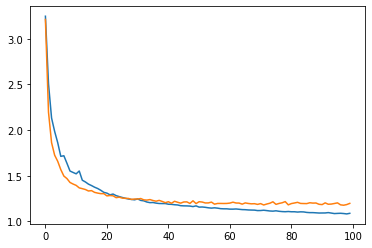

In [16]:
import matplotlib.pyplot as plt
import tqdm


def iterate_batches(data, batch_size, device):
    x, y, max_len = [], [], 0
    for k in tqdm.tqdm(range(len(data))):
        item = data[k]
        x.append([sym2idx[sym] for sym in ["<start>"] + list(item)])
        y.append([sym2idx[sym] for sym in list(item) + ["<end>"]])
        max_len = max(max_len, len(x[-1]))
        if len(x) == batch_size or k + 1 == len(data):
            for i in range(len(x)):
                x[i] = x[i] + [sym2idx["<empty>"] for _ in range(max_len - len(x[i]))]
                y[i] = y[i] + [sym2idx["<empty>"] for _ in range(max_len - len(y[i]))]
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)
            yield x, y
            x, y, max_len = [], [], 0
        

def train_epoch(data, model):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = torch.optim.AdamW(model.parameters())
    total_loss, total_count = 0.0, 1e-38
    random.shuffle(data)
    for inputs, answers in iterate_batches(data, batch_size, device):
        optimizer.zero_grad()
        #print(inputs.shape)
        #print(answers.shape)
        outputs = model(inputs)
        #print(outputs.shape)
        outputs = outputs.transpose(1, 2)
        #print(outputs.shape)
        #print("")
        loss = loss_function(outputs, answers)
        total_loss += (loss.item() * inputs.shape[0])
        total_count += inputs.shape[0]
        loss.backward()
        optimizer.step()
    return total_loss / total_count

def test_epoch(data, model):
    with torch.no_grad():
        model.eval()
        loss_function = torch.nn.CrossEntropyLoss()
        total_loss, total_count = 0.0, 1e-38
        for inputs, answers in iterate_batches(data, batch_size, device):
            outputs = model(inputs)
            outputs = outputs.transpose(1, 2)
            loss = loss_function(outputs, answers)
            total_loss += (loss.item() * inputs.shape[0])
            total_count += inputs.shape[0]
        return total_loss / total_count

train_losses, test_losses = [], []
for i in range(epoch_count):
    train_loss = train_epoch(train, model)
    test_loss = test_epoch(test, model)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print("Epoch {} loss: {:.5f} {:.5f}".format(i, train_loss, test_loss))
    print(generate(model, max_seq_len))
    print("")
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()